In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydot

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

import time

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, linewidth=1000, precision=9)
np.random.seed(0)

In [2]:
train_dev = pd.read_csv("../data/train.csv", index_col=0)
train_dev[['Soil_Type7']].describe()

,Soil_Type7
count,15120.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [4]:
# Save Y to an array
train_dev_Y = np.array(np.array(train_dev["Cover_Type"].tolist()))

# Binarize Y
def binarizeY(data):
    binarized_data = np.zeros((data.size,10))
    for j in range(0,data.size):
        feature = data[j:j+1]
        i = feature.astype(np.int64) 
        binarized_data[j,i]=1
    return binarized_data

train_dev_Y_bi = binarizeY(train_dev_Y)

# Pull out the features to normalize
X_norm_feat_list = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

train_dev_X_norm = np.array(train_dev[X_norm_feat_list])

print(train_dev_X_norm[0,:])

normer = preprocessing.StandardScaler()
# print(normer.fit_transform(train_dev_X_norm))
train_dev_X_norm = normer.fit_transform(train_dev_X_norm)

print(train_dev_X_norm[0,:])

# Pull out the wilderness area features
X_wild_feat_list = [
    'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'
]

train_dev_X_wild = np.array(train_dev[X_wild_feat_list])

# Pull out the soil area features
X_soil_feat_list = [
    'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
    'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
    'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
    'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
    'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
]

train_dev_X_soil = np.array(train_dev[X_soil_feat_list])

# Choose features 
feature_list = X_norm_feat_list + X_soil_feat_list

# Stich together the normalized and binarized features
train_dev_X = np.concatenate((train_dev_X_norm, train_dev_X_soil), axis=1)
print(train_dev_X[0,:])

[2596   51    3  258    0  510  221  232  148 6279]
[-0.367095118 -0.959979824 -1.597131627  0.146639411 -0.834074226 -0.908681308  0.271453733  0.571653464  0.281258883  4.334805162]
[-0.367095118 -0.959979824 -1.597131627  0.146639411 -0.834074226 -0.908681308  0.271453733  0.571653464  0.281258883  4.334805162  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           1.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.         ]


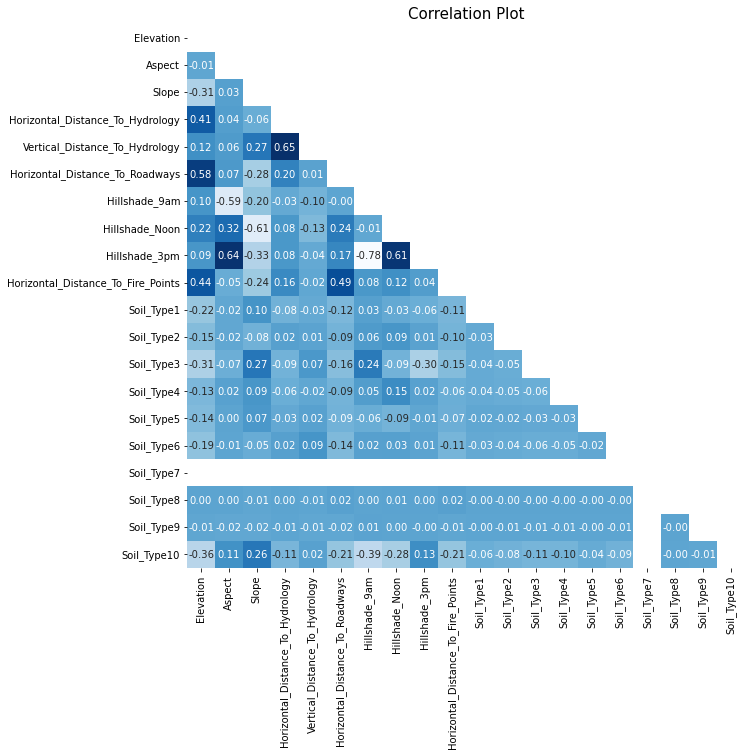

In [5]:
# correlation plot
corr = train_dev[feature_list].iloc[:, 0:20].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

In [7]:
n = train_dev_X.shape[0]

shuffle = np.random.permutation(np.arange(n))
train_dev_X, train_dev_Y = train_dev_X[shuffle], train_dev_Y[shuffle]

percent_in_dev = .2
dev_slice = int(percent_in_dev * n)

# Set some variables to dev and training data.
dev_dat, dev_lab = train_dev_X[:dev_slice], train_dev_Y[:dev_slice]
train_dat, train_lab = train_dev_X[dev_slice:], train_dev_Y[dev_slice:]

n_dev = dev_dat.shape[0]
n_train = train_dat.shape[0]
n_feat = train_dat.shape[1]
n_class = 7

# def binarizeY(data):
#     binarized_data = np.zeros((data.size,10))
#     for j in range(0,data.size):
#         feature = data[j:j+1]
#         i = feature.astype(np.int64) 
#         binarized_data[j,i]=1
#     return binarized_data

# train_lab_b = binarizeY(train_lab)
# dev_lab_b = binarizeY(dev_lab)
# n_class = train_lab_b[1].size

print(f'Dev size: {n_dev}')
print(f'Train size: {n_train}')
print(f'Features: {n_feat}')
print(f'Classes: {n_class}')
print(f'Dev example: {dev_dat[0,:]}')
print(f'Train example: {train_dat[0,:]}')
print(f'Train lab head: {train_lab[:10]}')
print(f'Dev lab head: {dev_lab[:10]}')
print(feature_list)
# pd.DataFrame(train_dat[:,9:115]).describe()

Dev size: 3024
Train size: 12096
Features: 50
Classes: 7
Dev example: [-1.267339483 -1.259755916 -0.532502386 -1.081532285 -0.834074226 -0.668685391 -0.05576844  -0.173920954  0.106942908 -1.054775128  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           1.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0.         ]
Train example: [ 1.478884684  1.247462308 -0.8873788    0.322772561 -0.360507272 -0.183410627 -0.5466017    0.834797376  1.022101777 -0.592005835  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.           0

In [8]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

start_time = time.time()
rf.fit(train_dat, train_lab)
print(f'Train time = {time.time() - start_time}')

start_time = time.time()
rf_pred = rf.predict(dev_dat).astype(int)
print(f'Train time = {time.time() - start_time}')

Train time = 8.840627193450928
Train time = 0.05797600746154785


,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.588752,0.564417,0.497592,0.341243,0.158140,0.038168,0.989130,0.399471,0.453920,0.445768
recall,0.763098,0.223844,0.741627,0.689498,0.158879,0.021231,0.217184,0.399471,0.402194,0.399471
f1-score,0.664683,0.320557,0.595581,0.456538,0.158508,0.027285,0.356164,0.399471,0.368474,0.364546
support,439.000000,411.000000,418.000000,438.000000,428.000000,471.000000,419.000000,0.399471,3024.000000,3024.000000


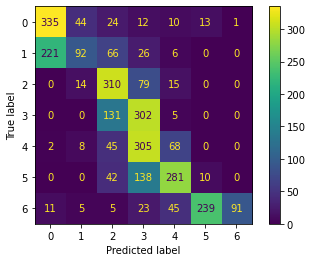

In [9]:
cm = confusion_matrix(dev_lab, rf_pred)

ConfusionMatrixDisplay(cm).plot()

pd.DataFrame(classification_report(dev_lab, rf_pred, output_dict=True))

In [10]:
rf.feature_importances_

array([0.413257446, 0.03467798 , 0.027395155, 0.045487433, 0.043187348, 0.094645969, 0.032467449, 0.031538817, 0.037890403, 0.080562039, 0.000764574, 0.001733465, 0.000968152, 0.002854837, 0.000575415, 0.001276185, 0.         , 0.         , 0.000361058, 0.006268482, 0.001543413, 0.01319949 , 0.00403377 , 0.000226822, 0.         , 0.000822605, 0.001828184, 0.000083705, 0.000316053, 0.002463305, 0.000036854, 0.006410617, 0.003028784, 0.001593214, 0.000045036, 0.00135811 , 0.000423809, 0.000054137, 0.007917464, 0.005498671, 0.003080778, 0.012004905, 0.003980349, 0.001004017, 0.006757863, 0.000168544, 0.000018726, 0.025464779, 0.035436266, 0.005287525])

In [ ]:
# # Pull out one tree from the forest
# tree = rf.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')